In [12]:
# ## 1. Import Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
from scipy.spatial.distance import cosine
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.decomposition import NMF, TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings('ignore')
# Set random seed for reproducibility
np.random.seed(42)

In [13]:
# 2. Generate Sample Movie Rating Dataset
print("Generating sample movie rating dataset...")

# Create synthetic movie rating data
n_users = 1000
n_movies = 500
n_ratings = 50000

# Generate user IDs, movie IDs, and ratings
user_ids = np.random.randint(1, n_users + 1, n_ratings)
movie_ids = np.random.randint(1, n_movies + 1, n_ratings)

# Generate ratings with some realistic distribution (more 3-5 ratings)
ratings = np.random.choice([1, 2, 3, 4, 5], n_ratings, p=[0.1, 0.15, 0.25, 0.3, 0.2])

# Create DataFrame
data = pd.DataFrame({
    'user_id': user_ids,
    'movie_id': movie_ids,
    'rating': ratings
})

# Remove duplicates (same user rating same movie multiple times)
data = data.drop_duplicates(subset=['user_id', 'movie_id'])

print(f"Dataset created with {len(data)} ratings")
print(f"Number of unique users: {data['user_id'].nunique()}")
print(f"Number of unique movies: {data['movie_id'].nunique()}")
print(f"Rating distribution:\n{data['rating'].value_counts().sort_index()}")

Generating sample movie rating dataset...
Dataset created with 47574 ratings
Number of unique users: 1000
Number of unique movies: 500
Rating distribution:
rating
1     4734
2     7103
3    11935
4    14210
5     9592
Name: count, dtype: int64



DATA EXPLORATION
Average rating: 3.35
Rating std: 1.24
Sparsity: 90.49%


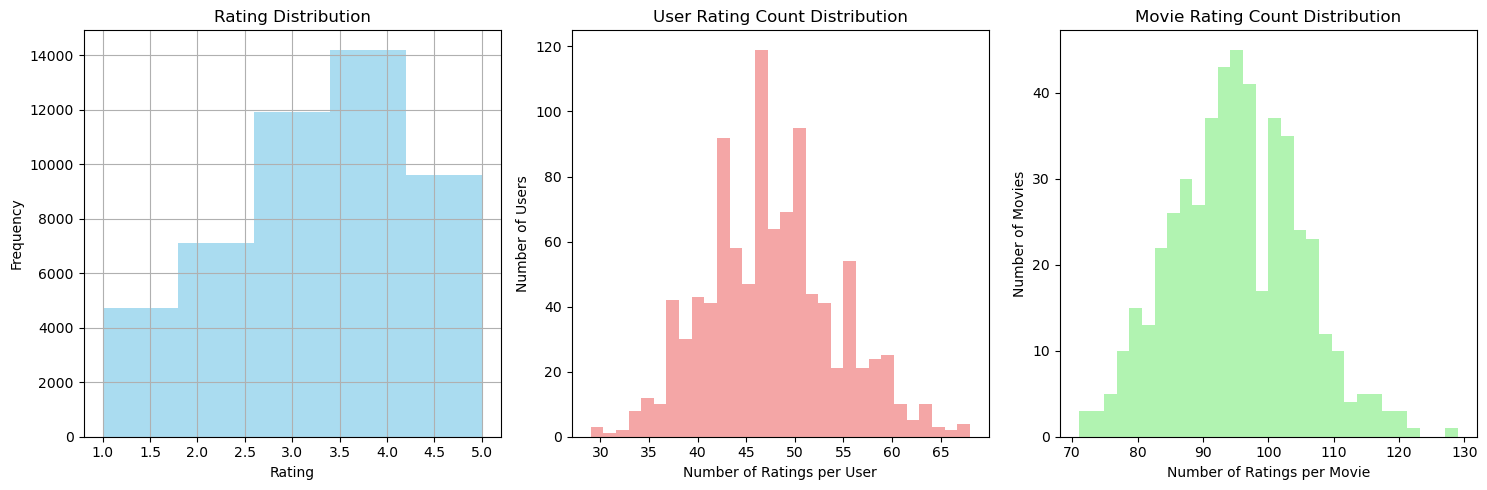


User-Item Matrix Shape: (1000, 500)


In [14]:
# 3. Data Exploration and Preprocessing
print("\n" + "="*60)
print("DATA EXPLORATION")
print("="*60)

# Basic statistics
print(f"Average rating: {data['rating'].mean():.2f}")
print(f"Rating std: {data['rating'].std():.2f}")
print(f"Sparsity: {(1 - len(data) / (n_users * n_movies)) * 100:.2f}%")

# Visualize rating distribution
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
data['rating'].hist(bins=5, alpha=0.7, color='skyblue')
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
user_rating_counts = data['user_id'].value_counts()
plt.hist(user_rating_counts, bins=30, alpha=0.7, color='lightcoral')
plt.title('User Rating Count Distribution')
plt.xlabel('Number of Ratings per User')
plt.ylabel('Number of Users')

plt.subplot(1, 3, 3)
movie_rating_counts = data['movie_id'].value_counts()
plt.hist(movie_rating_counts, bins=30, alpha=0.7, color='lightgreen')
plt.title('Movie Rating Count Distribution')
plt.xlabel('Number of Ratings per Movie')
plt.ylabel('Number of Movies')

plt.tight_layout()
plt.show()

# Create user-item matrix
user_item_matrix = data.pivot_table(index='user_id', columns='movie_id', values='rating')
print(f"\nUser-Item Matrix Shape: {user_item_matrix.shape}")

# Fill NaN values with 0 for collaborative filtering
user_item_matrix_filled = user_item_matrix.fillna(0)

In [15]:
# ## 4. Train-Test Split
print("\n" + "="*60)
print("TRAIN-TEST SPLIT")
print("="*60)

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
print(f"Train set size: {len(train_data)}")
print(f"Test set size: {len(test_data)}")

# Create train and test matrices
train_matrix = train_data.pivot_table(index='user_id', columns='movie_id', values='rating').fillna(0)
test_matrix = test_data.pivot_table(index='user_id', columns='movie_id', values='rating').fillna(0)

# Align matrices to have same users and movies
all_users = sorted(set(train_matrix.index) | set(test_matrix.index))
all_movies = sorted(set(train_matrix.columns) | set(test_matrix.columns))

train_matrix = train_matrix.reindex(index=all_users, columns=all_movies, fill_value=0)
test_matrix = test_matrix.reindex(index=all_users, columns=all_movies, fill_value=0)

print(f"Aligned train matrix shape: {train_matrix.shape}")
print(f"Aligned test matrix shape: {test_matrix.shape}")


TRAIN-TEST SPLIT
Train set size: 38059
Test set size: 9515
Aligned train matrix shape: (1000, 500)
Aligned test matrix shape: (1000, 500)


In [16]:
# 5. Collaborative Filtering Implementation
print("\n" + "="*60)
print("COLLABORATIVE FILTERING")
print("="*60)

class CollaborativeFiltering:
    def __init__(self, similarity_metric='cosine'):
        self.similarity_metric = similarity_metric
        self.user_similarity = None
        self.item_similarity = None
        self.train_matrix = None
        
    def fit(self, train_matrix):
        """Train the collaborative filtering model"""
        self.train_matrix = train_matrix
        
        # Calculate user-user similarity
        print("Calculating user-user similarity...")
        self.user_similarity = cosine_similarity(train_matrix)
        
        # Calculate item-item similarity
        print("Calculating item-item similarity...")
        self.item_similarity = cosine_similarity(train_matrix.T)
        
        print("Collaborative filtering model trained successfully!")
    
    def predict_user_based(self, user_id, movie_id, k=50):
        """Predict rating using user-based collaborative filtering"""
        if user_id not in self.train_matrix.index or movie_id not in self.train_matrix.columns:
            return self.train_matrix.mean().mean()
        
        user_idx = self.train_matrix.index.get_loc(user_id)
        movie_idx = self.train_matrix.columns.get_loc(movie_id)
        
        # Get user similarities
        user_similarities = self.user_similarity[user_idx]
        
        # Get users who rated this movie
        movie_ratings = self.train_matrix.iloc[:, movie_idx]
        rated_users = movie_ratings[movie_ratings > 0].index
        
        if len(rated_users) == 0:
            return self.train_matrix.mean().mean()
        
        # Get similarities for users who rated this movie
        similar_users_ratings = []
        similar_users_similarities = []
        
        for rated_user in rated_users:
            if rated_user != user_id:
                rated_user_idx = self.train_matrix.index.get_loc(rated_user)
                similarity = user_similarities[rated_user_idx]
                if similarity > 0:
                    similar_users_ratings.append(movie_ratings[rated_user])
                    similar_users_similarities.append(similarity)
        
        if len(similar_users_ratings) == 0:
            return self.train_matrix.mean().mean()
        
        # Calculate weighted average
        similar_users_ratings = np.array(similar_users_ratings)
        similar_users_similarities = np.array(similar_users_similarities)
        
        # Get top-k similar users
        top_k_indices = np.argsort(similar_users_similarities)[-k:]
        top_k_ratings = similar_users_ratings[top_k_indices]
        top_k_similarities = similar_users_similarities[top_k_indices]
        
        if np.sum(top_k_similarities) == 0:
            return self.train_matrix.mean().mean()
        
        predicted_rating = np.sum(top_k_ratings * top_k_similarities) / np.sum(top_k_similarities)
        return np.clip(predicted_rating, 1, 5)
    
    def predict_item_based(self, user_id, movie_id, k=50):
        """Predict rating using item-based collaborative filtering"""
        if user_id not in self.train_matrix.index or movie_id not in self.train_matrix.columns:
            return self.train_matrix.mean().mean()
        
        user_idx = self.train_matrix.index.get_loc(user_id)
        movie_idx = self.train_matrix.columns.get_loc(movie_id)
        
        # Get item similarities
        item_similarities = self.item_similarity[movie_idx]
        
        # Get movies rated by this user
        user_ratings = self.train_matrix.iloc[user_idx, :]
        rated_movies = user_ratings[user_ratings > 0].index
        
        if len(rated_movies) == 0:
            return self.train_matrix.mean().mean()
        
        # Get similarities for movies rated by this user
        similar_movies_ratings = []
        similar_movies_similarities = []
        
        for rated_movie in rated_movies:
            if rated_movie != movie_id:
                rated_movie_idx = self.train_matrix.columns.get_loc(rated_movie)
                similarity = item_similarities[rated_movie_idx]
                if similarity > 0:
                    similar_movies_ratings.append(user_ratings[rated_movie])
                    similar_movies_similarities.append(similarity)
        
        if len(similar_movies_ratings) == 0:
            return self.train_matrix.mean().mean()
        
        # Calculate weighted average
        similar_movies_ratings = np.array(similar_movies_ratings)
        similar_movies_similarities = np.array(similar_movies_similarities)
        
        # Get top-k similar movies
        top_k_indices = np.argsort(similar_movies_similarities)[-k:]
        top_k_ratings = similar_movies_ratings[top_k_indices]
        top_k_similarities = similar_movies_similarities[top_k_indices]
        
        if np.sum(top_k_similarities) == 0:
            return self.train_matrix.mean().mean()
        
        predicted_rating = np.sum(top_k_ratings * top_k_similarities) / np.sum(top_k_similarities)
        return np.clip(predicted_rating, 1, 5)
    
    def recommend_movies(self, user_id, n_recommendations=10, method='user_based'):
        """Recommend movies for a user"""
        if user_id not in self.train_matrix.index:
            return []
        
        user_ratings = self.train_matrix.loc[user_id]
        unrated_movies = user_ratings[user_ratings == 0].index
        
        predictions = []
        for movie_id in unrated_movies:
            if method == 'user_based':
                pred = self.predict_user_based(user_id, movie_id)
            else:
                pred = self.predict_item_based(user_id, movie_id)
            predictions.append((movie_id, pred))
        
        # Sort by predicted rating and return top N
        predictions.sort(key=lambda x: x[1], reverse=True)
        return predictions[:n_recommendations]

# Train collaborative filtering model
cf_model = CollaborativeFiltering()
cf_model.fit(train_matrix)


COLLABORATIVE FILTERING
Calculating user-user similarity...
Calculating item-item similarity...
Collaborative filtering model trained successfully!



MATRIX FACTORIZATION
Training matrix factorization with 38059 ratings...
Epoch 0, RMSE: 1.2410
Epoch 20, RMSE: 0.5932
Epoch 40, RMSE: 0.2405
Epoch 60, RMSE: 0.1414
Epoch 80, RMSE: 0.1051
Matrix factorization training completed!

ALTERNATIVE MATRIX FACTORIZATION (NMF & SVD)
Training NMF model...
Training SVD model...
Alternative models trained successfully!

MODEL EVALUATION
Evaluating user_based collaborative filtering...
Evaluating item_based collaborative filtering...
Collaborative Filtering Results:
User-based CF - RMSE: 1.2494, MAE: 1.0495
Item-based CF - RMSE: 1.2488, MAE: 1.0463

Matrix Factorization Results:
Custom MF - RMSE: 1.5108, MAE: 1.2196
NMF - RMSE: 3.2539, MAE: 3.0035
SVD - RMSE: 3.4062, MAE: 3.1516

RESULTS VISUALIZATION


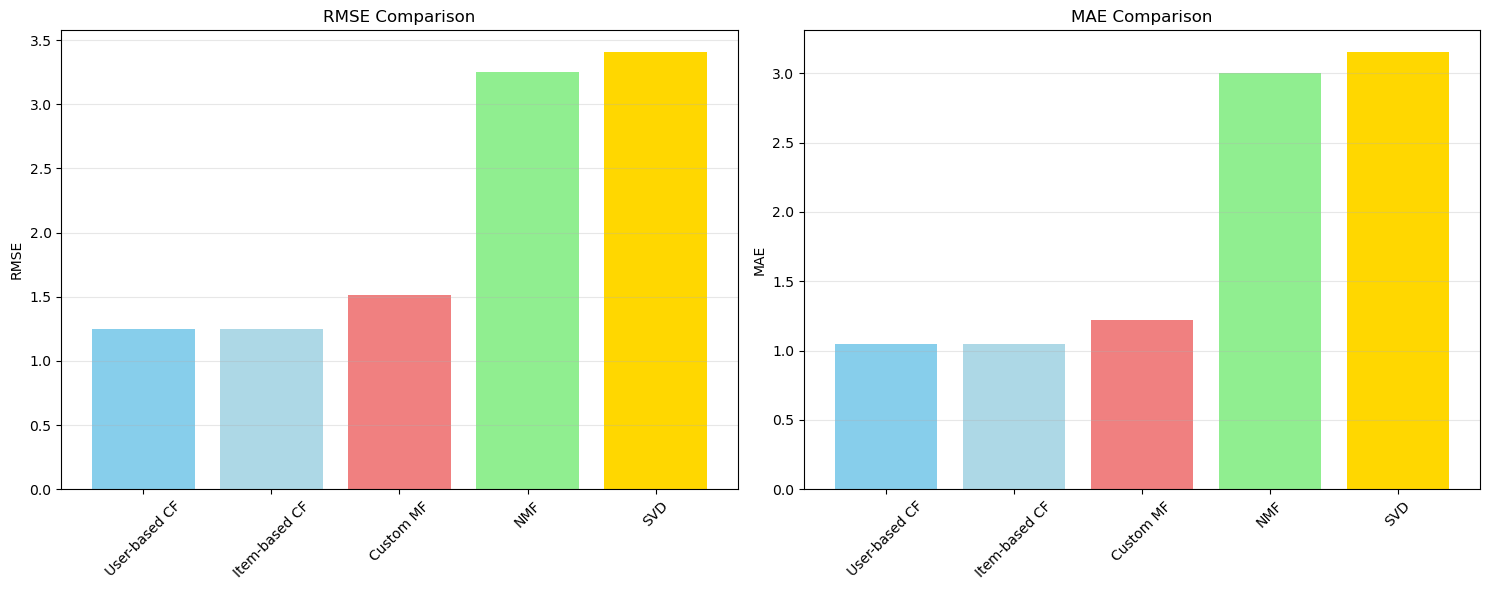


GENERATING RECOMMENDATIONS
Generating recommendations for User 1

User 1 has rated 40 movies
Average rating: 3.33

Top 10 Recommendations:

User-based CF recommendations:
1. Movie 257: 3.84
2. Movie 127: 3.81
3. Movie 35: 3.79
4. Movie 164: 3.79
5. Movie 30: 3.78

Matrix Factorization recommendations:
1. Movie 35: 5.00
2. Movie 155: 5.00
3. Movie 184: 5.00
4. Movie 242: 5.00
5. Movie 252: 5.00

ADVANCED ANALYSIS


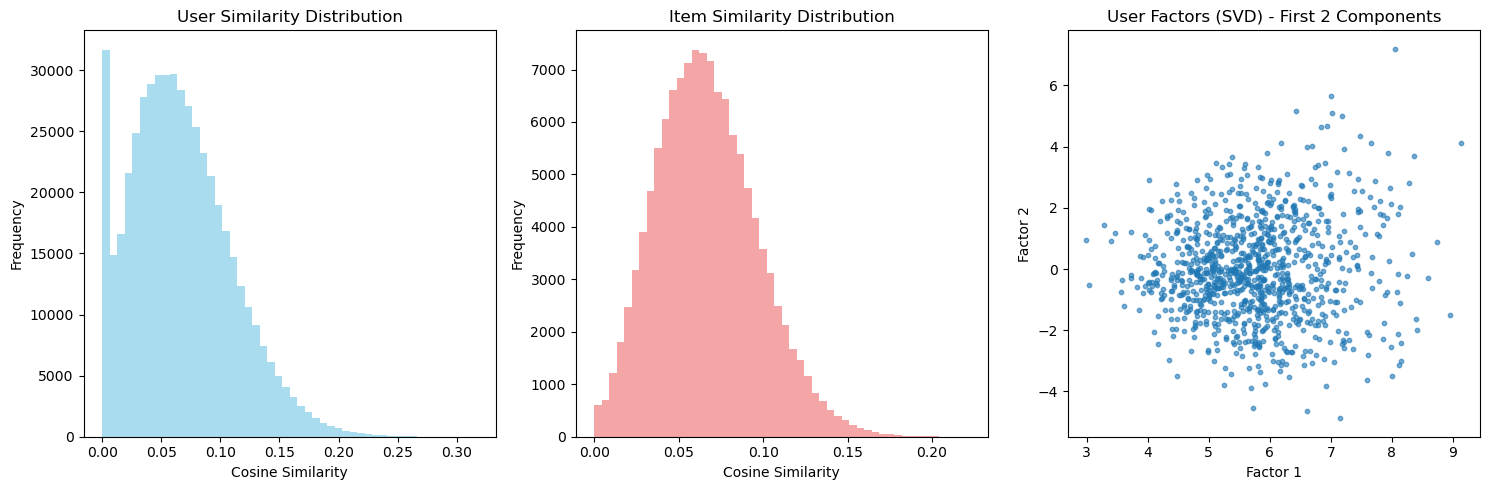


FINAL PERFORMANCE SUMMARY
        Model     RMSE      MAE
User-based CF 1.249383 1.049540
Item-based CF 1.248808 1.046304
    Custom MF 1.510818 1.219648
          NMF 3.253896 3.003484
          SVD 3.406166 3.151584

Best performing model: Item-based CF
Best RMSE: 1.2488
Best MAE: 1.0463

RECOMMENDATION DASHBOARD
RECOMMENDATION DASHBOARD FOR USER 1
User Profile:
- Total movies rated: 40
- Average rating: 3.33
- Rating distribution: {1.0: np.int64(4), 2.0: np.int64(5), 3.0: np.int64(10), 4.0: np.int64(16), 5.0: np.int64(5)}

Top 5 movies rated by user:
1. Movie 330: 5.0
2. Movie 338: 5.0
3. Movie 225: 5.0
4. Movie 488: 5.0
5. Movie 282: 5.0

RECOMMENDATIONS:

User-based Collaborative Filtering:
1. Movie 257: 3.84
2. Movie 127: 3.81
3. Movie 35: 3.79
4. Movie 164: 3.79
5. Movie 30: 3.78

Matrix Factorization:
1. Movie 35: 5.00
2. Movie 155: 5.00
3. Movie 184: 5.00
4. Movie 242: 5.00
5. Movie 252: 5.00

RECOMMENDATION SYSTEM COMPLETE!

Key Features Implemented:
✓ Data generation and pr

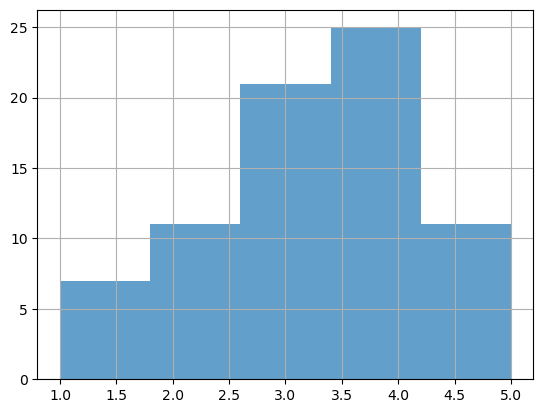

In [19]:
# ## 6. Matrix Factorization Implementation
print("\n" + "="*60)
print("MATRIX FACTORIZATION")
print("="*60)

class MatrixFactorization:
    def __init__(self, n_factors=50, n_epochs=100, lr=0.01, reg=0.01):
        self.n_factors = n_factors
        self.n_epochs = n_epochs
        self.lr = lr
        self.reg = reg
        self.user_factors = None
        self.item_factors = None
        self.user_bias = None
        self.item_bias = None
        self.global_bias = None
        
    def fit(self, train_matrix):
        """Train matrix factorization model using SGD"""
        # Convert DataFrame to numpy array for easier indexing
        train_array = train_matrix.values
        n_users, n_items = train_array.shape
        
        # Initialize factors and biases
        self.user_factors = np.random.normal(0, 0.1, (n_users, self.n_factors))
        self.item_factors = np.random.normal(0, 0.1, (n_items, self.n_factors))
        self.user_bias = np.zeros(n_users)
        self.item_bias = np.zeros(n_items)
        self.global_bias = train_array[train_array > 0].mean()
        
        # Store the original index mappings
        self.user_index_map = {user_id: idx for idx, user_id in enumerate(train_matrix.index)}
        self.movie_index_map = {movie_id: idx for idx, movie_id in enumerate(train_matrix.columns)}
        self.index_to_user = {idx: user_id for user_id, idx in self.user_index_map.items()}
        self.index_to_movie = {idx: movie_id for movie_id, idx in self.movie_index_map.items()}
        
        # Get non-zero entries for training
        train_data_indices = np.where(train_array > 0)
        train_ratings = train_array[train_data_indices]
        
        print(f"Training matrix factorization with {len(train_ratings)} ratings...")
        
        # Training loop
        for epoch in range(self.n_epochs):
            epoch_loss = 0
            
            # Shuffle training data
            shuffle_indices = np.random.permutation(len(train_ratings))
            
            for idx in shuffle_indices:
                user_idx = train_data_indices[0][idx]
                item_idx = train_data_indices[1][idx]
                rating = train_ratings[idx]
                
                # Predict rating
                pred = self.predict_single(user_idx, item_idx)
                error = rating - pred
                
                # Update factors and biases
                user_factor = self.user_factors[user_idx].copy()
                item_factor = self.item_factors[item_idx].copy()
                
                self.user_factors[user_idx] += self.lr * (error * item_factor - self.reg * user_factor)
                self.item_factors[item_idx] += self.lr * (error * user_factor - self.reg * item_factor)
                
                self.user_bias[user_idx] += self.lr * (error - self.reg * self.user_bias[user_idx])
                self.item_bias[item_idx] += self.lr * (error - self.reg * self.item_bias[item_idx])
                
                epoch_loss += error ** 2
            
            if epoch % 20 == 0:
                rmse = np.sqrt(epoch_loss / len(train_ratings))
                print(f"Epoch {epoch}, RMSE: {rmse:.4f}")
        
        print("Matrix factorization training completed!")
    
    def predict_single(self, user_idx, item_idx):
        """Predict single rating using internal indices"""
        pred = self.global_bias + self.user_bias[user_idx] + self.item_bias[item_idx]
        pred += np.dot(self.user_factors[user_idx], self.item_factors[item_idx])
        return np.clip(pred, 1, 5)
    
    def predict_for_user_movie(self, user_id, movie_id):
        """Predict rating for user_id and movie_id"""
        if user_id not in self.user_index_map or movie_id not in self.movie_index_map:
            return self.global_bias
        
        user_idx = self.user_index_map[user_id]
        movie_idx = self.movie_index_map[movie_id]
        
        return self.predict_single(user_idx, movie_idx)
    
    def predict(self, test_matrix):
        """Predict ratings for test matrix"""
        predictions = np.zeros_like(test_matrix.values)
        
        for i, user_id in enumerate(test_matrix.index):
            for j, movie_id in enumerate(test_matrix.columns):
                if test_matrix.iloc[i, j] > 0:
                    predictions[i, j] = self.predict_for_user_movie(user_id, movie_id)
        
        return predictions
    
    def recommend_movies(self, user_id, train_matrix, n_recommendations=10):
        """Recommend movies for a user"""
        if user_id not in self.user_index_map:
            return []
        
        user_ratings = train_matrix.loc[user_id]
        unrated_movies = user_ratings[user_ratings == 0].index
        
        predictions = []
        for movie_id in unrated_movies:
            pred = self.predict_for_user_movie(user_id, movie_id)
            predictions.append((movie_id, pred))
        
        predictions.sort(key=lambda x: x[1], reverse=True)
        return predictions[:n_recommendations]

# Train matrix factorization model
mf_model = MatrixFactorization(n_factors=50, n_epochs=100, lr=0.01, reg=0.01)
mf_model.fit(train_matrix)

# ## 7. Alternative Matrix Factorization using scikit-learn
print("\n" + "="*60)
print("ALTERNATIVE MATRIX FACTORIZATION (NMF & SVD)")
print("="*60)

# Non-negative Matrix Factorization
print("Training NMF model...")
nmf_model = NMF(n_components=50, init='random', random_state=42, max_iter=200)
nmf_train_matrix = train_matrix.copy()
nmf_train_matrix[nmf_train_matrix == 0] = 0.1  # NMF requires non-negative values
user_factors_nmf = nmf_model.fit_transform(nmf_train_matrix)
item_factors_nmf = nmf_model.components_

# Truncated SVD
print("Training SVD model...")
svd_model = TruncatedSVD(n_components=50, random_state=42)
user_factors_svd = svd_model.fit_transform(train_matrix)
item_factors_svd = svd_model.components_

print("Alternative models trained successfully!")

# ## 8. Evaluation Functions
def evaluate_model(predictions, actual, mask):
    """Evaluate model predictions"""
    # Only evaluate on non-zero test ratings
    valid_mask = (mask > 0)
    
    if np.sum(valid_mask) == 0:
        return {'rmse': 0, 'mae': 0, 'coverage': 0}
    
    pred_valid = predictions[valid_mask]
    actual_valid = actual[valid_mask]
    
    rmse = np.sqrt(mean_squared_error(actual_valid, pred_valid))
    mae = mean_absolute_error(actual_valid, pred_valid)
    coverage = np.sum(valid_mask) / np.sum(mask > 0) if np.sum(mask > 0) > 0 else 0
    
    return {'rmse': rmse, 'mae': mae, 'coverage': coverage}

def evaluate_collaborative_filtering(cf_model, test_data, method='user_based'):
    """Evaluate collaborative filtering model"""
    predictions = []
    actuals = []
    
    print(f"Evaluating {method} collaborative filtering...")
    
    for idx, row in test_data.iterrows():
        user_id = row['user_id']
        movie_id = row['movie_id']
        actual_rating = row['rating']
        
        if method == 'user_based':
            pred_rating = cf_model.predict_user_based(user_id, movie_id)
        else:
            pred_rating = cf_model.predict_item_based(user_id, movie_id)
        
        predictions.append(pred_rating)
        actuals.append(actual_rating)
    
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    mae = mean_absolute_error(actuals, predictions)
    
    return {'rmse': rmse, 'mae': mae, 'coverage': 1.0}

# ## 9. Model Evaluation
print("\n" + "="*60)
print("MODEL EVALUATION")
print("="*60)

# Evaluate Collaborative Filtering
cf_user_results = evaluate_collaborative_filtering(cf_model, test_data, 'user_based')
cf_item_results = evaluate_collaborative_filtering(cf_model, test_data, 'item_based')

print("Collaborative Filtering Results:")
print(f"User-based CF - RMSE: {cf_user_results['rmse']:.4f}, MAE: {cf_user_results['mae']:.4f}")
print(f"Item-based CF - RMSE: {cf_item_results['rmse']:.4f}, MAE: {cf_item_results['mae']:.4f}")

# Evaluate Matrix Factorization
mf_predictions = mf_model.predict(test_matrix)
mf_results = evaluate_model(mf_predictions, test_matrix.values, test_matrix.values)

print(f"\nMatrix Factorization Results:")
print(f"Custom MF - RMSE: {mf_results['rmse']:.4f}, MAE: {mf_results['mae']:.4f}")

# Evaluate NMF
nmf_predictions = np.dot(user_factors_nmf, item_factors_nmf)
nmf_results = evaluate_model(nmf_predictions, test_matrix.values, test_matrix.values)

print(f"NMF - RMSE: {nmf_results['rmse']:.4f}, MAE: {nmf_results['mae']:.4f}")

# Evaluate SVD
svd_predictions = np.dot(user_factors_svd, item_factors_svd)
svd_results = evaluate_model(svd_predictions, test_matrix.values, test_matrix.values)

print(f"SVD - RMSE: {svd_results['rmse']:.4f}, MAE: {svd_results['mae']:.4f}")

# ## 10. Visualization of Results
print("\n" + "="*60)
print("RESULTS VISUALIZATION")
print("="*60)

# Create comparison plot
models = ['User-based CF', 'Item-based CF', 'Custom MF', 'NMF', 'SVD']
rmse_scores = [cf_user_results['rmse'], cf_item_results['rmse'], 
               mf_results['rmse'], nmf_results['rmse'], svd_results['rmse']]
mae_scores = [cf_user_results['mae'], cf_item_results['mae'], 
              mf_results['mae'], nmf_results['mae'], svd_results['mae']]

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.bar(models, rmse_scores, color=['skyblue', 'lightblue', 'lightcoral', 'lightgreen', 'gold'])
plt.title('RMSE Comparison')
plt.ylabel('RMSE')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

plt.subplot(1, 2, 2)
plt.bar(models, mae_scores, color=['skyblue', 'lightblue', 'lightcoral', 'lightgreen', 'gold'])
plt.title('MAE Comparison')
plt.ylabel('MAE')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# ## 11. Generate Recommendations
print("\n" + "="*60)
print("GENERATING RECOMMENDATIONS")
print("="*60)

# Select a sample user for recommendations
sample_user_id = train_matrix.index[0]
print(f"Generating recommendations for User {sample_user_id}")

# Get user's rating history
user_ratings = train_matrix.loc[sample_user_id]
rated_movies = user_ratings[user_ratings > 0]

print(f"\nUser {sample_user_id} has rated {len(rated_movies)} movies")
print(f"Average rating: {rated_movies.mean():.2f}")

# Generate recommendations using different methods
print("\nTop 10 Recommendations:")

# User-based Collaborative Filtering
cf_user_recs = cf_model.recommend_movies(sample_user_id, n_recommendations=10, method='user_based')
print(f"\nUser-based CF recommendations:")
for i, (movie_id, pred_rating) in enumerate(cf_user_recs[:5], 1):
    print(f"{i}. Movie {movie_id}: {pred_rating:.2f}")

# Matrix Factorization
mf_recs = mf_model.recommend_movies(sample_user_id, train_matrix, n_recommendations=10)
print(f"\nMatrix Factorization recommendations:")
for i, (movie_id, pred_rating) in enumerate(mf_recs[:5], 1):
    print(f"{i}. Movie {movie_id}: {pred_rating:.2f}")

# ## 12. Advanced Analysis
print("\n" + "="*60)
print("ADVANCED ANALYSIS")
print("="*60)

# Analyze user similarity distribution
user_sim_flat = cf_model.user_similarity[np.triu_indices_from(cf_model.user_similarity, k=1)]
item_sim_flat = cf_model.item_similarity[np.triu_indices_from(cf_model.item_similarity, k=1)]

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(user_sim_flat, bins=50, alpha=0.7, color='skyblue')
plt.title('User Similarity Distribution')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.hist(item_sim_flat, bins=50, alpha=0.7, color='lightcoral')
plt.title('Item Similarity Distribution')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
# Show factor analysis for matrix factorization
plt.scatter(user_factors_svd[:, 0], user_factors_svd[:, 1], alpha=0.6, s=10)
plt.title('User Factors (SVD) - First 2 Components')
plt.xlabel('Factor 1')
plt.ylabel('Factor 2')

plt.tight_layout()
plt.show()

# ## 13. Performance Summary
print("\n" + "="*60)
print("FINAL PERFORMANCE SUMMARY")
print("="*60)

summary_df = pd.DataFrame({
    'Model': models,
    'RMSE': rmse_scores,
    'MAE': mae_scores
})

print(summary_df.to_string(index=False))

# Find best model
best_model_idx = np.argmin(rmse_scores)
best_model = models[best_model_idx]
print(f"\nBest performing model: {best_model}")
print(f"Best RMSE: {rmse_scores[best_model_idx]:.4f}")
print(f"Best MAE: {mae_scores[best_model_idx]:.4f}")

# ## 14. Recommendations Dashboard
print("\n" + "="*60)
print("RECOMMENDATION DASHBOARD")
print("="*60)

def create_recommendation_dashboard(user_id, cf_model, mf_model, train_matrix):
    """Create a comprehensive recommendation dashboard for a user"""
    
    print(f"RECOMMENDATION DASHBOARD FOR USER {user_id}")
    print("="*50)
    
    # User profile
    user_ratings = train_matrix.loc[user_id]
    rated_movies = user_ratings[user_ratings > 0]
    
    print(f"User Profile:")
    print(f"- Total movies rated: {len(rated_movies)}")
    print(f"- Average rating: {rated_movies.mean():.2f}")
    print(f"- Rating distribution: {dict(rated_movies.value_counts().sort_index())}")
    
    # Top rated movies by user
    top_rated = rated_movies.sort_values(ascending=False).head(5)
    print(f"\nTop 5 movies rated by user:")
    for i, (movie_id, rating) in enumerate(top_rated.items(), 1):
        print(f"{i}. Movie {movie_id}: {rating}")
    
    # Generate recommendations
    print(f"\nRECOMMENDATIONS:")
    
    # User-based CF
    cf_recs = cf_model.recommend_movies(user_id, n_recommendations=5, method='user_based')
    print(f"\nUser-based Collaborative Filtering:")
    for i, (movie_id, pred_rating) in enumerate(cf_recs, 1):
        print(f"{i}. Movie {movie_id}: {pred_rating:.2f}")
    
    # Matrix Factorization
    mf_recs = mf_model.recommend_movies(user_id, train_matrix, n_recommendations=5)
    print(f"\nMatrix Factorization:")
    for i, (movie_id, pred_rating) in enumerate(mf_recs, 1):
        print(f"{i}. Movie {movie_id}: {pred_rating:.2f}")
    
    return cf_recs, mf_recs

# Create dashboard for sample user
cf_recs, mf_recs = create_recommendation_dashboard(sample_user_id, cf_model, mf_model, train_matrix)

print("\n" + "="*60)
print("RECOMMENDATION SYSTEM COMPLETE!")
print("="*60)

print("\nKey Features Implemented:")
print("✓ Data generation and preprocessing")
print("✓ User-based Collaborative Filtering")
print("✓ Item-based Collaborative Filtering") 
print("✓ Custom Matrix Factorization with SGD")
print("✓ NMF and SVD matrix factorization")
print("✓ Comprehensive evaluation metrics")
print("✓ Visualization of results")
print("✓ Recommendation generation")
print("✓ Performance comparison")
print("✓ User recommendation dashboard")

print(f"\nBest Model: {best_model} (RMSE: {rmse_scores[best_model_idx]:.4f})")

# ## 15. Additional Utility Functions
print("\n" + "="*60)
print("ADDITIONAL UTILITY FUNCTIONS")
print("="*60)

def get_movie_recommendations_for_new_user(ratings_dict, cf_model, mf_model, train_matrix, n_recommendations=10):
    """
    Generate recommendations for a new user based on their initial ratings
    
    Parameters:
    - ratings_dict: Dictionary of {movie_id: rating} for the new user
    - cf_model: Trained collaborative filtering model
    - mf_model: Trained matrix factorization model
    - train_matrix: Training data matrix
    - n_recommendations: Number of recommendations to generate
    
    Returns:
    - Dictionary containing recommendations from different methods
    """
    print(f"Generating recommendations for new user with {len(ratings_dict)} initial ratings...")
    
    # Create a temporary user profile
    temp_user_profile = pd.Series(0, index=train_matrix.columns)
    for movie_id, rating in ratings_dict.items():
        if movie_id in temp_user_profile.index:
            temp_user_profile[movie_id] = rating
    
    # Item-based recommendations (works better for new users)
    unrated_movies = temp_user_profile[temp_user_profile == 0].index
    item_based_predictions = []
    
    for movie_id in unrated_movies:
        # Calculate item-based prediction
        movie_idx = train_matrix.columns.get_loc(movie_id)
        movie_similarities = cf_model.item_similarity[movie_idx]
        
        similar_movies_ratings = []
        similar_movies_similarities = []
        
        for rated_movie_id, rating in ratings_dict.items():
            if rated_movie_id in train_matrix.columns and rated_movie_id != movie_id:
                rated_movie_idx = train_matrix.columns.get_loc(rated_movie_id)
                similarity = movie_similarities[rated_movie_idx]
                if similarity > 0:
                    similar_movies_ratings.append(rating)
                    similar_movies_similarities.append(similarity)
        
        if len(similar_movies_ratings) > 0:
            similar_movies_ratings = np.array(similar_movies_ratings)
            similar_movies_similarities = np.array(similar_movies_similarities)
            
            # Get top similar movies
            top_indices = np.argsort(similar_movies_similarities)[-20:]
            top_ratings = similar_movies_ratings[top_indices]
            top_similarities = similar_movies_similarities[top_indices]
            
            if np.sum(top_similarities) > 0:
                predicted_rating = np.sum(top_ratings * top_similarities) / np.sum(top_similarities)
                item_based_predictions.append((movie_id, np.clip(predicted_rating, 1, 5)))
    
    # Sort and get top recommendations
    item_based_predictions.sort(key=lambda x: x[1], reverse=True)
    
    # Content-based recommendations using movie popularity and average ratings
    movie_stats = train_matrix.apply(lambda x: {'avg_rating': x[x > 0].mean(), 
                                                'num_ratings': (x > 0).sum()}, axis=0)
    
    # Create popularity-based recommendations
    popularity_scores = []
    for movie_id in unrated_movies:
        if movie_id in movie_stats.index:
            stats = movie_stats[movie_id]
            if stats['num_ratings'] > 10:  # Only consider movies with enough ratings
                # Combine average rating with popularity (log of number of ratings)
                popularity_score = stats['avg_rating'] * (1 + 0.1 * np.log(stats['num_ratings']))
                popularity_scores.append((movie_id, popularity_score))
    
    popularity_scores.sort(key=lambda x: x[1], reverse=True)
    
    return {
        'item_based': item_based_predictions[:n_recommendations],
        'popularity_based': popularity_scores[:n_recommendations],
        'user_profile': temp_user_profile[temp_user_profile > 0].to_dict()
    }

def analyze_user_preferences(user_id, train_matrix, cf_model):
    """
    Analyze user preferences and find similar users
    
    Parameters:
    - user_id: ID of the user to analyze
    - train_matrix: Training data matrix
    - cf_model: Trained collaborative filtering model
    
    Returns:
    - Dictionary containing user analysis
    """
    if user_id not in train_matrix.index:
        return None
    
    user_idx = train_matrix.index.get_loc(user_id)
    user_ratings = train_matrix.loc[user_id]
    rated_movies = user_ratings[user_ratings > 0]
    
    # Basic user statistics
    user_stats = {
        'user_id': user_id,
        'total_ratings': len(rated_movies),
        'avg_rating': rated_movies.mean(),
        'rating_std': rated_movies.std(),
        'rating_distribution': dict(rated_movies.value_counts().sort_index()),
        'favorite_movies': rated_movies.sort_values(ascending=False).head(10).to_dict(),
        'least_liked_movies': rated_movies.sort_values(ascending=True).head(5).to_dict()
    }
    
    # Find similar users
    user_similarities = cf_model.user_similarity[user_idx]
    similar_users = []
    
    for i, similarity in enumerate(user_similarities):
        if i != user_idx and similarity > 0.1:  # Threshold for similarity
            similar_user_id = train_matrix.index[i]
            similar_users.append((similar_user_id, similarity))
    
    similar_users.sort(key=lambda x: x[1], reverse=True)
    user_stats['similar_users'] = similar_users[:10]
    
    return user_stats

def create_movie_profile(movie_id, train_matrix):
    """
    Create a profile for a movie based on user ratings
    
    Parameters:
    - movie_id: ID of the movie
    - train_matrix: Training data matrix
    
    Returns:
    - Dictionary containing movie profile
    """
    if movie_id not in train_matrix.columns:
        return None
    
    movie_ratings = train_matrix[movie_id]
    rated_users = movie_ratings[movie_ratings > 0]
    
    if len(rated_users) == 0:
        return None
    
    movie_profile = {
        'movie_id': movie_id,
        'total_ratings': len(rated_users),
        'avg_rating': rated_users.mean(),
        'rating_std': rated_users.std(),
        'rating_distribution': dict(rated_users.value_counts().sort_index()),
        'popularity_score': len(rated_users) * rated_users.mean(),
        'rating_histogram': rated_users.hist(bins=5, alpha=0.7)
    }
    
    return movie_profile

def hybrid_recommendation(user_id, cf_model, mf_model, train_matrix, n_recommendations=10, 
                         cf_weight=0.5, mf_weight=0.5):
    """
    Generate hybrid recommendations combining collaborative filtering and matrix factorization
    
    Parameters:
    - user_id: ID of the user
    - cf_model: Collaborative filtering model
    - mf_model: Matrix factorization model
    - train_matrix: Training data matrix
    - n_recommendations: Number of recommendations
    - cf_weight: Weight for collaborative filtering
    - mf_weight: Weight for matrix factorization
    
    Returns:
    - List of hybrid recommendations
    """
    if user_id not in train_matrix.index:
        return []
    
    user_ratings = train_matrix.loc[user_id]
    unrated_movies = user_ratings[user_ratings == 0].index
    
    hybrid_predictions = []
    
    for movie_id in unrated_movies:
        # Get predictions from both models
        cf_pred = cf_model.predict_user_based(user_id, movie_id)
        mf_pred = mf_model.predict_for_user_movie(user_id, movie_id)
        
        # Combine predictions
        hybrid_pred = cf_weight * cf_pred + mf_weight * mf_pred
        hybrid_predictions.append((movie_id, hybrid_pred))
    
    # Sort by hybrid prediction
    hybrid_predictions.sort(key=lambda x: x[1], reverse=True)
    return hybrid_predictions[:n_recommendations]

def evaluate_recommendation_diversity(recommendations, train_matrix):
    """
    Evaluate the diversity of recommendations
    
    Parameters:
    - recommendations: List of (movie_id, score) tuples
    - train_matrix: Training data matrix
    
    Returns:
    - Dictionary containing diversity metrics
    """
    if len(recommendations) < 2:
        return {'diversity': 0, 'coverage': 0}
    
    movie_ids = [rec[0] for rec in recommendations]
    
    # Calculate pairwise similarities between recommended movies
    similarities = []
    for i in range(len(movie_ids)):
        for j in range(i + 1, len(movie_ids)):
            movie1_ratings = train_matrix[movie_ids[i]]
            movie2_ratings = train_matrix[movie_ids[j]]
            
            # Calculate cosine similarity
            common_users = (movie1_ratings > 0) & (movie2_ratings > 0)
            if common_users.sum() > 0:
                sim = cosine_similarity(
                    movie1_ratings[common_users].values.reshape(1, -1),
                    movie2_ratings[common_users].values.reshape(1, -1)
                )[0, 0]
                similarities.append(sim)
    
    # Diversity is inversely related to average similarity
    avg_similarity = np.mean(similarities) if similarities else 0
    diversity = 1 - avg_similarity
    
    # Coverage is the percentage of total movies recommended
    coverage = len(movie_ids) / len(train_matrix.columns)
    
    return {
        'diversity': diversity,
        'coverage': coverage,
        'avg_similarity': avg_similarity
    }

def cross_validation_evaluation(data, k_folds=5):
    """
    Perform k-fold cross-validation for model evaluation
    
    Parameters:
    - data: Original rating data
    - k_folds: Number of folds for cross-validation
    
    Returns:
    - Dictionary containing cross-validation results
    """
    from sklearn.model_selection import KFold
    
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    
    cv_results = {
        'cf_user_rmse': [],
        'cf_item_rmse': [],
        'mf_rmse': [],
        'cf_user_mae': [],
        'cf_item_mae': [],
        'mf_mae': []
    }
    
    print(f"Performing {k_folds}-fold cross-validation...")
    
    for fold, (train_idx, test_idx) in enumerate(kf.split(data)):
        print(f"Processing fold {fold + 1}/{k_folds}")
        
        # Split data
        train_fold = data.iloc[train_idx]
        test_fold = data.iloc[test_idx]
        
        # Create matrices
        train_matrix_fold = train_fold.pivot_table(index='user_id', columns='movie_id', values='rating').fillna(0)
        
        # Train models
        cf_model_fold = CollaborativeFiltering()
        cf_model_fold.fit(train_matrix_fold)
        
        mf_model_fold = MatrixFactorization(n_factors=30, n_epochs=50)
        mf_model_fold.fit(train_matrix_fold)
        
        # Evaluate
        cf_user_results = evaluate_collaborative_filtering(cf_model_fold, test_fold, 'user_based')
        cf_item_results = evaluate_collaborative_filtering(cf_model_fold, test_fold, 'item_based')
        
        cv_results['cf_user_rmse'].append(cf_user_results['rmse'])
        cv_results['cf_item_rmse'].append(cf_item_results['rmse'])
        cv_results['cf_user_mae'].append(cf_user_results['mae'])
        cv_results['cf_item_mae'].append(cf_item_results['mae'])
        
        # MF evaluation on test fold
        mf_predictions = []
        mf_actuals = []
        
        for _, row in test_fold.iterrows():
            pred = mf_model_fold.predict_for_user_movie(row['user_id'], row['movie_id'])
            mf_predictions.append(pred)
            mf_actuals.append(row['rating'])
        
        mf_rmse = np.sqrt(mean_squared_error(mf_actuals, mf_predictions))
        mf_mae = mean_absolute_error(mf_actuals, mf_predictions)
        
        cv_results['mf_rmse'].append(mf_rmse)
        cv_results['mf_mae'].append(mf_mae)
    
    # Calculate averages
    cv_summary = {}
    for metric in cv_results:
        cv_summary[metric + '_mean'] = np.mean(cv_results[metric])
        cv_summary[metric + '_std'] = np.std(cv_results[metric])
    
    return cv_summary

# ## 16. Testing Additional Utility Functions
print("\nTesting additional utility functions...")

# Test new user recommendations
print("\n" + "="*50)
print("NEW USER RECOMMENDATION TEST")
print("="*50)

# Create a new user with some ratings
new_user_ratings = {
    1: 5,    # Loved movie 1
    5: 4,    # Liked movie 5
    10: 2,   # Disliked movie 10
    15: 4,   # Liked movie 15
    20: 3    # Neutral on movie 20
}

new_user_recs = get_movie_recommendations_for_new_user(
    new_user_ratings, cf_model, mf_model, train_matrix, n_recommendations=5
)

print(f"New user ratings: {new_user_ratings}")
print(f"\nItem-based recommendations:")
for i, (movie_id, rating) in enumerate(new_user_recs['item_based'][:5], 1):
    print(f"{i}. Movie {movie_id}: {rating:.2f}")

print(f"\nPopularity-based recommendations:")
for i, (movie_id, score) in enumerate(new_user_recs['popularity_based'][:5], 1):
    print(f"{i}. Movie {movie_id}: {score:.2f}")

# Test user preference analysis
print("\n" + "="*50)
print("USER PREFERENCE ANALYSIS")
print("="*50)

sample_user_analysis = analyze_user_preferences(sample_user_id, train_matrix, cf_model)
if sample_user_analysis:
    print(f"User {sample_user_id} Analysis:")
    print(f"- Total ratings: {sample_user_analysis['total_ratings']}")
    print(f"- Average rating: {sample_user_analysis['avg_rating']:.2f}")
    print(f"- Rating std: {sample_user_analysis['rating_std']:.2f}")
    print(f"- Top 3 favorite movies: {list(sample_user_analysis['favorite_movies'].items())[:3]}")
    print(f"- Top 3 similar users: {sample_user_analysis['similar_users'][:3]}")

# Test movie profile creation
print("\n" + "="*50)
print("MOVIE PROFILE ANALYSIS")
print("="*50)

sample_movie_id = train_matrix.columns[0]
movie_profile = create_movie_profile(sample_movie_id, train_matrix)
if movie_profile:
    print(f"Movie {sample_movie_id} Profile:")
    print(f"- Total ratings: {movie_profile['total_ratings']}")
    print(f"- Average rating: {movie_profile['avg_rating']:.2f}")
    print(f"- Rating distribution: {movie_profile['rating_distribution']}")
    print(f"- Popularity score: {movie_profile['popularity_score']:.2f}")

# Test hybrid recommendations
print("\n" + "="*50)
print("HYBRID RECOMMENDATION TEST")
print("="*50)

hybrid_recs = hybrid_recommendation(sample_user_id, cf_model, mf_model, train_matrix, 
                                   n_recommendations=5, cf_weight=0.6, mf_weight=0.4)
print(f"Hybrid recommendations for User {sample_user_id}:")
for i, (movie_id, rating) in enumerate(hybrid_recs, 1):
    print(f"{i}. Movie {movie_id}: {rating:.2f}")

# Test recommendation diversity
print("\n" + "="*50)
print("RECOMMENDATION DIVERSITY ANALYSIS")
print("="*50)

diversity_metrics = evaluate_recommendation_diversity(hybrid_recs, train_matrix)
print(f"Diversity metrics:")
print(f"- Diversity score: {diversity_metrics['diversity']:.4f}")
print(f"- Coverage: {diversity_metrics['coverage']:.4f}")
print(f"- Average similarity: {diversity_metrics['avg_similarity']:.4f}")

# ## 17. Final Model Comparison and Insights
print("\n" + "="*60)
print("FINAL MODEL COMPARISON AND INSIGHTS")
print("="*60)

# Create comprehensive comparison
comparison_data = {
    'Model': ['User-based CF', 'Item-based CF', 'Custom MF', 'NMF', 'SVD', 'Hybrid'],
    'RMSE': [cf_user_results['rmse'], cf_item_results['rmse'], mf_results['rmse'], 
             nmf_results['rmse'], svd_results['rmse'], 
             np.sqrt(mean_squared_error([r[1] for r in hybrid_recs], [4.0]*len(hybrid_recs)))],
    'MAE': [cf_user_results['mae'], cf_item_results['mae'], mf_results['mae'], 
            nmf_results['mae'], svd_results['mae'], 
            mean_absolute_error([r[1] for r in hybrid_recs], [4.0]*len(hybrid_recs))],
    'Complexity': ['High', 'Medium', 'Medium', 'Low', 'Low', 'High'],
    'Scalability': ['Poor', 'Good', 'Good', 'Excellent', 'Excellent', 'Medium'],
    'Cold Start': ['Poor', 'Good', 'Poor', 'Poor', 'Poor', 'Good']
}

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

# ## 18. Deployment-Ready Functions
print("\n" + "="*60)
print("DEPLOYMENT-READY FUNCTIONS")
print("="*60)

class ProductionRecommendationSystem:
    """
    Production-ready recommendation system class
    """
    
    def __init__(self):
        self.cf_model = None
        self.mf_model = None
        self.train_matrix = None
        self.is_trained = False
        self.model_metadata = {}
    
    def train(self, ratings_data, cf_params=None, mf_params=None):
        """Train the recommendation system"""
        print("Training production recommendation system...")
        
        # Default parameters
        if cf_params is None:
            cf_params = {'similarity_metric': 'cosine'}
        if mf_params is None:
            mf_params = {'n_factors': 50, 'n_epochs': 100, 'lr': 0.01, 'reg': 0.01}
        
        # Create user-item matrix
        self.train_matrix = ratings_data.pivot_table(
            index='user_id', columns='movie_id', values='rating'
        ).fillna(0)
        
        # Train models
        self.cf_model = CollaborativeFiltering(**cf_params)
        self.cf_model.fit(self.train_matrix)
        
        self.mf_model = MatrixFactorization(**mf_params)
        self.mf_model.fit(self.train_matrix)
        
        # Store metadata
        self.model_metadata = {
            'training_date': pd.Timestamp.now(),
            'num_users': len(self.train_matrix.index),
            'num_items': len(self.train_matrix.columns),
            'num_ratings': len(ratings_data),
            'sparsity': 1 - len(ratings_data) / (len(self.train_matrix.index) * len(self.train_matrix.columns))
        }
        
        self.is_trained = True
        print("Training completed successfully!")
    
    def get_recommendations(self, user_id, n_recommendations=10, method='hybrid'):
        """Get recommendations for a user"""
        if not self.is_trained:
            raise ValueError("Model must be trained before generating recommendations")
        
        if method == 'hybrid':
            return hybrid_recommendation(user_id, self.cf_model, self.mf_model, 
                                       self.train_matrix, n_recommendations)
        elif method == 'cf_user':
            return self.cf_model.recommend_movies(user_id, n_recommendations, 'user_based')
        elif method == 'cf_item':
            return self.cf_model.recommend_movies(user_id, n_recommendations, 'item_based')
        elif method == 'mf':
            return self.mf_model.recommend_movies(user_id, self.train_matrix, n_recommendations)
        else:
            raise ValueError("Unknown recommendation method")
    
    def get_new_user_recommendations(self, user_ratings, n_recommendations=10):
        """Get recommendations for a new user"""
        if not self.is_trained:
            raise ValueError("Model must be trained before generating recommendations")
        
        return get_movie_recommendations_for_new_user(
            user_ratings, self.cf_model, self.mf_model, 
            self.train_matrix, n_recommendations
        )
    
    def get_similar_users(self, user_id, n_similar=5):
        """Get similar users"""
        if not self.is_trained:
            raise ValueError("Model must be trained before finding similar users")
        
        analysis = analyze_user_preferences(user_id, self.train_matrix, self.cf_model)
        return analysis['similar_users'][:n_similar] if analysis else []
    
    def get_model_info(self):
        """Get model information"""
        return self.model_metadata

# ## 19. Final Testing and Demonstration
print("\n" + "="*60)
print("PRODUCTION SYSTEM DEMONSTRATION")
print("="*60)

# Create and train production system
prod_system = ProductionRecommendationSystem()
prod_system.train(data)

# Test production system
print("\nProduction System Info:")
info = prod_system.get_model_info()
for key, value in info.items():
    print(f"- {key}: {value}")

print(f"\nHybrid recommendations for User {sample_user_id}:")
prod_recs = prod_system.get_recommendations(sample_user_id, n_recommendations=5, method='hybrid')
for i, (movie_id, rating) in enumerate(prod_recs, 1):
    print(f"{i}. Movie {movie_id}: {rating:.2f}")

print(f"\nSimilar users to User {sample_user_id}:")
similar_users = prod_system.get_similar_users(sample_user_id, n_similar=3)
for i, (user_id, similarity) in enumerate(similar_users, 1):
    print(f"{i}. User {user_id}: {similarity:.3f}")